In [25]:

import sys
import os
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import lancedb
from embeddings import CLIPEmbeddings
from multimodal_lancedb import MultimodalLanceDB


LANCEDB_HOST_FILE = ".lancedb"
TBL_NAME = "test_tbl"
db = lancedb.connect(LANCEDB_HOST_FILE)

embedder = CLIPEmbeddings()
# Creating a LanceDB vector store
vectorstore = MultimodalLanceDB(
    uri=LANCEDB_HOST_FILE, embedding=embedder, table_name=TBL_NAME
)
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 2})
user_query = "a ship"
results = retriever.invoke(user_query)

In [12]:

img_url = "../" + results[0].metadata['extracted_frame_path']


[{'type': 'text',
  'text': 'Retrieved information: Document 1: effectively carry out a C2 architecture by teaching configuring implementing and maintaining small form factor Network and Data Systems Marines also be trained in the network fundamentals integrating into the global Network and their\n\nDocument 2: in the execution of each element of communications and how these skills apply to force [Applause] design the ECC has five phases Each of which teaches the core discipline of\n\nMy question: a ship'},
 {'type': 'image_url',
  'image_url': {'url': ''}},
 {'type': 'image_url',
  'image_url': {'url': ''}}]
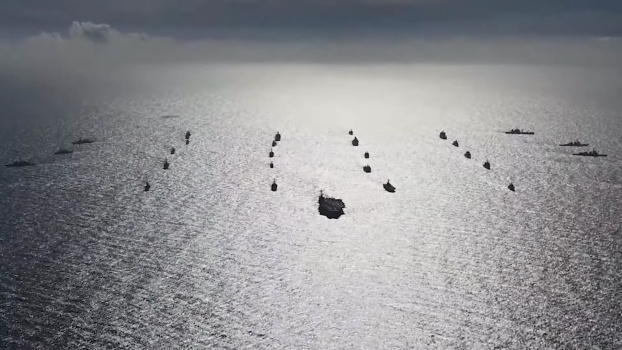
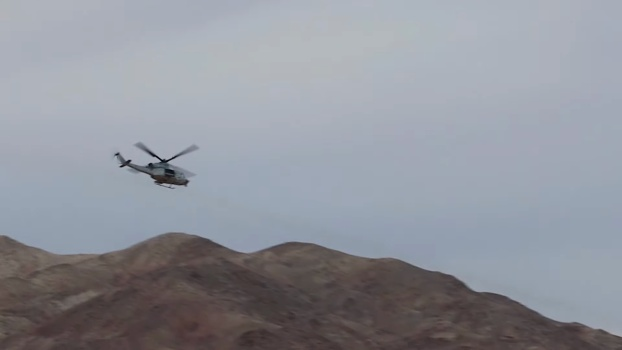

In [29]:
def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

formatted_context = "\n\n".join([f"Document {i+1}: {doc.metadata['transcript']}" for i, doc in enumerate(results)])
base64_images = "\n\n".join([f"Image {i+1}: {encode_image_to_base64("../"+doc.metadata['extracted_frame_path'])}" for i, doc in enumerate(results)])

content_array = [
    {"type": "text", "text": f"Retrieved information: {formatted_context}\n\nMy question: {user_query}"},
]

# Add each JPG image to the content array
for i, doc in enumerate(results):
    # Encode the image
    base64_image = encode_image_to_base64("../"+doc.metadata['extracted_frame_path'])
    
    # Add to content array with JPEG mime type
    content_array.append({
        "type": "image_url",
        "image_url": {"url": f"data:image/jpg;base64,{base64_image}"}
    })

content_array

In [30]:
from openai import OpenAI
import os
import base64
from dotenv import load_dotenv

load_dotenv()

client = OpenAI(
    api_key=os.environ.get("OPENAI_API_KEY"),
)

# Get the base64 string
base64_image = encode_image_to_base64(img_url)


# Create the messages array with both text and image
chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "system",
            "content": "You are a helpful assistant analyzing both images and text. Use the retrieved information to answer the user's question in a clear and concise way."
        },
        {
            "role": "user",
            "content": content_array
        }
    ],
    model="gpt-4o-mini",
)

print(chat_completion.choices[0].message.content)

It looks like you’ve shared two images featuring naval vessels and a helicopter, but I can't identify or describe them further. 

If you have specific questions about naval operations, communication systems, or the context of the images, feel free to ask!


In [5]:
# import dataclasses
# from typing import Any, Dict, Iterator, List, Optional, Sequence, TextIO, Union
# from enum import Enum, auto

# class SeparatorStyle(Enum):
#     """Different separator style."""

#     SINGLE = auto()

# @dataclasses.dataclass
# class Conversation:
#     """A class that keeps all conversation history"""

#     system: str
#     roles: List[str]
#     messages: List[List[str]]
#     map_roles: Dict[str, str]
#     version: str = "Unknown"
#     sep_style: SeparatorStyle = SeparatorStyle.SINGLE
#     sep: str = "\n"

#     def _get_prompt_role(self, role):
#         if self.map_roles is not None and role in self.map_roles.keys():
#             return self.map_roles[role]
#         else:
#             return role

#     def _build_content_for_first_message_in_conversation(
#         self, first_message: List[str]
#     ):
#         content = []
#         if len(first_message) != 2:
#             raise TypeError(
#                 "First message in Conversation needs to include a prompt and a base64-enconded image!"
#             )

#         prompt, b64_image = first_message[0], first_message[1]

#         # handling prompt
#         if prompt is None:
#             raise TypeError("API does not support None prompt yet")
#         content.append({"type": "text", "text": prompt})
#         if b64_image is None:
#             raise TypeError("API does not support text only conversation yet")

#         # handling image
#         if not isBase64(b64_image):
#             raise TypeError(
#                 "Image in Conversation's first message must be stored under base64 encoding!"
#             )

#         content.append(
#             {
#                 "type": "image_url",
#                 "image_url": {
#                     "url": b64_image,
#                 },
#             }
#         )
#         return content

#     def _build_content_for_follow_up_messages_in_conversation(
#         self, follow_up_message: List[str]
#     ):
#         if follow_up_message is not None and len(follow_up_message) > 1:
#             raise TypeError(
#                 "Follow-up message in Conversation must not include an image!"
#             )

#         # handling text prompt
#         if follow_up_message is None or follow_up_message[0] is None:
#             raise TypeError(
#                 "Follow-up message in Conversation must include exactly one text message"
#             )

#         text = follow_up_message[0]
#         return text

#     def get_message(self):
#         messages = self.messages
#         api_messages = []
#         for i, msg in enumerate(messages):
#             role, message_content = msg
#             if i == 0:
#                 # get content for very first message in conversation
#                 content = self._build_content_for_first_message_in_conversation(
#                     message_content
#                 )
#             else:
#                 # get content for follow-up message in conversation
#                 content = self._build_content_for_follow_up_messages_in_conversation(
#                     message_content
#                 )

#             api_messages.append(
#                 {
#                     "role": role,
#                     "content": content,
#                 }
#             )
#         return api_messages

#     # this method helps represent a multi-turn chat into as a single turn chat format
#     def serialize_messages(self):
#         messages = self.messages
#         ret = ""
#         if self.sep_style == SeparatorStyle.SINGLE:
#             if self.system is not None and self.system != "":
#                 ret = self.system + self.sep
#             for i, (role, message) in enumerate(messages):
#                 role = self._get_prompt_role(role)
#                 if message:
#                     if isinstance(message, List):
#                         # get prompt only
#                         message = message[0]
#                     if i == 0:
#                         # do not include role at the beginning
#                         ret += message
#                     else:
#                         ret += role + ": " + message
#                     if i < len(messages) - 1:
#                         # avoid including sep at the end of serialized message
#                         ret += self.sep
#                 else:
#                     ret += role + ":"
#         else:
#             raise ValueError(f"Invalid style: {self.sep_style}")

#         return ret

#     def append_message(self, role, message):
#         if len(self.messages) == 0:
#             # data verification for the very first message
#             assert (
#                 role == self.roles[0]
#             ), f"the very first message in conversation must be from role {self.roles[0]}"
#             assert (
#                 len(message) == 2
#             ), f"the very first message in conversation must include both prompt and an image"
#             prompt, image = message[0], message[1]
#             assert prompt is not None, f"prompt must be not None"
#             assert isBase64(image), f"image must be under base64 encoding"
#         else:
#             # data verification for follow-up message
#             assert (
#                 role in self.roles
#             ), f"the follow-up message must be from one of the roles {self.roles}"
#             assert (
#                 len(message) == 1
#             ), f"the follow-up message must consist of one text message only, no image"

#         self.messages.append([role, message])

#     def copy(self):
#         return Conversation(
#             system=self.system,
#             roles=self.roles,
#             messages=[[x, y] for x, y in self.messages],
#             version=self.version,
#             map_roles=self.map_roles,
#         )

#     def dict(self):
#         return {
#             "system": self.system,
#             "roles": self.roles,
#             "messages": [[x, y[0] if len(y) == 1 else y] for x, y in self.messages],
#             "version": self.version,
#         }


In [4]:
# OPENAI
import os
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=openai_api_key)

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Say this is a test",
        }
    ],
    model="gpt-4o",
)

chat_completion

ChatCompletion(id='chatcmpl-B8w5jEfTLy9fKnvnk8RKztlQX1Qak', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='This is a test.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1741469627, model='gpt-4o-2024-08-06', object='chat.completion', service_tier='default', system_fingerprint='fp_eb9dce56a8', usage=CompletionUsage(completion_tokens=6, prompt_tokens=12, total_tokens=18, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0)))

In [ ]:
import PIL
import base64

def isBase64(sb):
    try:
        if isinstance(sb, str):
            # If there's any unicode here, an exception will be thrown and the function will return false
            sb_bytes = bytes(sb, "ascii")
        elif isinstance(sb, bytes):
            sb_bytes = sb
        else:
            raise ValueError("Argument must be string or bytes")
        return base64.b64encode(base64.b64decode(sb_bytes)) == sb_bytes
    except Exception:
        return False

# encoding image at given path or PIL Image using base64
def encode_image(image_path_or_PIL_img):
    if isinstance(image_path_or_PIL_img, PIL.Image.Image):
        # this is a PIL image
        buffered = BytesIO()
        image_path_or_PIL_img.save(buffered, format="JPEG")
        return base64.b64encode(buffered.getvalue()).decode("utf-8")
    else:
        # this is a image_path
        with open(image_path_or_PIL_img, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")


prediction_guard_llava_conv = Conversation(
    system="",
    roles=("user", "assistant"),
    messages=[],
    version="Prediction Guard LLaVA enpoint Conversation v0",
    sep_style=SeparatorStyle.SINGLE,
    map_roles={"user": "USER", "assistant": "ASSISTANT"},
)

# helper function to call chat completion endpoint of PredictionGuard given a prompt and an image
def lvlm_inference(
    prompt,
    image,
    max_tokens: int = 200,
    temperature: float = 0.95,
    top_p: float = 0.1,
    top_k: int = 10,
):
    # prepare conversation
    conversation = prediction_guard_llava_conv.copy()
    conversation.append_message(conversation.roles[0], [prompt, image])
    return lvlm_inference_with_conversation(
        conversation,
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
    )


def lvlm_inference_with_conversation(
    conversation,
    max_tokens: int = 200,
    temperature: float = 0.95,
    top_p: float = 0.1,
    top_k: int = 10,
):
    # get PredictionGuard client
    client = _getPredictionGuardClient()
    # get message from conversation
    messages = conversation.get_message()
    # call chat completion endpoint at Grediction Guard
    response = client.chat.completions.create(
        model="llava-1.5-7b-hf",
        messages=messages,
        max_tokens=max_tokens,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
    )
    return response["choices"][-1]["message"]["content"]



prompt = "Please describe the image in detail"
image_path = "../" + results[0].metadata['extracted_frame_path']
b64_img = encode_image(image_path)

# prepare conversation
img_captioning_conv = prediction_guard_llava_conv.copy()
img_captioning_conv.append_message('user', [prompt, b64_img])
# call chat completion endpoint from prediction guard
caption = lvlm_inference_with_conversation(img_captioning_conv)

NameError: name '_getPredictionGuardClient' is not defined

In [10]:
chat_completion.choices[0].message.content

'This is a test.'